In [25]:
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Process, Queue

In [26]:
class RandomAction:
    def __init__(self, n_states=19, left_reward=-1):
        self.n_states = n_states
        self.left_reward = left_reward
        self.reset()

    def reset(self):
        self.state = self.n_states // 2
        return self.state

    def step(self):
        action = np.random.choice([-1, 1])
        self.state += action
        if self.state < 0:
            return self.state, self.left_reward, True
        elif self.state >= self.n_states:
            return self.state, 1, True
        return self.state, 0, False

In [27]:
class SemiGradientTDLambda:
    def __init__(self, alpha, lamda, epi=10, do=False):
        self.V = np.zeros(19)
        self.alpha = alpha
        self.lamda = lamda
        self.gamma = 1
        self.epi = epi
        if do:
            self.do()

    def do(self):
        env = RandomAction()

        for episode in range(self.epi):
            state = env.reset()
            done = False

            z = np.zeros(19)

            
            while not done:
                next_state, reward, done = env.step()

                v_hat = np.zeros(19)
                v_hat[state] = 1
                z = self.gamma * self.lamda * z + v_hat

                if done:
                    delta = reward - self.V[state]
                else:
                    delta = reward + self.gamma * self.V[next_state] - self.V[state]
                self.V += self.alpha * delta * z

                state = next_state

In [28]:
def RMS_RA(V):
    V = np.array(V)
    return np.sqrt(np.mean((V - np.linspace(-1, 1, 21)[1:-1])**2))

In [29]:
q = Queue()

alphas = np.linspace(0, 1, 51)
lamda_s = [0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]

def work(alpha, rd_seed):
    np.random.seed(rd_seed)

    table_ = []
    for lamda in lamda_s:
        gs = [SemiGradientTDLambda(alpha, lamda, do=True) for _ in range(200)]
        TD_RMS = [RMS_RA(g.V) for g in gs]
        table_.append(np.mean(TD_RMS, axis=0))

    q.put((alpha, table_))

In [30]:
th_s = []

for alpha in alphas:
    th_s.append(Process(target=work, args=(alpha, np.random.randint(0, 1000000))))

for th in th_s:
    th.start()

for th in th_s:
    th.join()

/tmp/ipykernel_139197/2023763904.py:3: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.mean((V - np.linspace(-1, 1, 21)[1:-1])**2))
/tmp/ipykernel_139197/2023763904.py:3: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.mean((V - np.linspace(-1, 1, 21)[1:-1])**2))
/tmp/ipykernel_139197/3766764304.py:32: RuntimeWarning: overflow encountered in add
  self.V += self.alpha * delta * z
/tmp/ipykernel_139197/3766764304.py:32: RuntimeWarning: invalid value encountered in multiply
  self.V += self.alpha * delta * z
/tmp/ipykernel_139197/3766764304.py:31: RuntimeWarning: invalid value encountered in scalar subtract
  delta = reward + self.gamma * self.V[next_state] - self.V[state]
/tmp/ipykernel_139197/2023763904.py:3: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.mean((V - np.linspace(-1, 1, 21)[1:-1])**2))
/tmp/ipykernel_139197/3766764304.py:32: RuntimeWarning: invalid value encountered in add
  self.V += self.alpha * delta * z
/tmp/ip

In [31]:
table = []
for i in range(len(alphas)):
    table.append(q.get())
    table.sort(key=lambda x: x[0])
    n_table = np.array([x[1] for x in table])

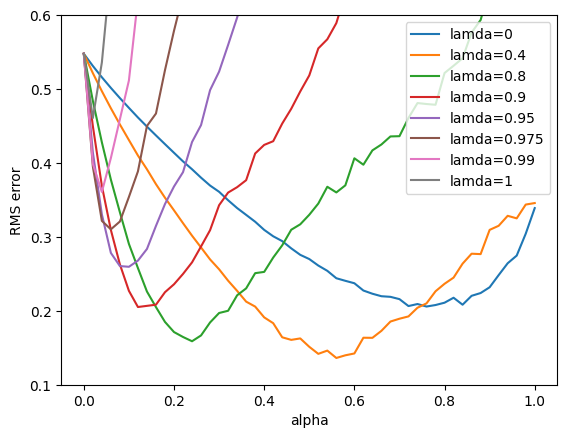

In [35]:
for i in range(len(lamda_s)):
    plt.plot(alphas, n_table[:, i], label=f'lamda={lamda_s[i]}')

plt.xlabel('alpha')
plt.ylabel('RMS error')
plt.legend()
plt.ylim([0.1, 0.6])
plt.show()